# Capstone

In [12]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification, make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf

#Comment out the below block to use GPU
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

from sklearn.grid_search import RandomizedSearchCV

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
 
import multiprocessing

from PIL import Image
import sys

import csv
%matplotlib inline
from keras import regularizers
from ann_visualizer.visualize import ann_viz;

## Importing Data and Processing

The following function is the code for importing data. It takes quite a while. It transcribes the 5 hand signs I chose as integers so they can be used with np_utils.to_categorical. The function returns the train test split of the data.


In [44]:
def funky_reader (path):
    df = pd.read_csv(path)
    columns = list(df.columns)
    columns[0] = "label"
    df.columns = columns
    transcribe = {
        'palm': 1,
        'index': 2, 
        'thumb': 3,
        'fist': 4,
        'l': 5
    }
    df.label = df.label.map(transcribe)
    X = df[df.columns[1:]].values
    y= df['label']
    X = X/255
    y = np_utils.to_categorical(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state =42)
    #Do not use if using CNN
    ss = StandardScaler()
    X_train_sc = ss.fit_transform(X_train)
    X_test_sc = ss.transform(X_test)
    X_train = X_train.reshape(X_train.shape[0], 120, 320, 1)
    X_test = X_test.reshape(X_test.shape[0], 120, 320, 1)
    return X_train, X_test, X_train_sc, X_test_sc, y_train, y_test

In [32]:
 X_train, X_test, X_train_sc, X_test_sc, y_train, y_test = funky_reader("../csv/data1.csv")

## Vanilla Neural Network

Below is the code for the Regular Neural Network originally made for comparison against the Convolutional Neural Network I made below. In a twist of fate, the Vanilla version is outperforming the CNN by quite a marigin. I've implemented an early stop here on the validation loss and a dropout of .5.

In [33]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

In [34]:
model = Sequential()
model.add(Dense(128, # How many neurons do you want in your first layer.
                input_shape=(38400,),
                activation='relu'))
model.add(Dropout(.5))
model.add(Dense(y_train.shape[1], activation = 'softmax'))

model.compile (optimizer = 'adam', metrics = ['accuracy'], loss = 'categorical_crossentropy')

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')



In [35]:
history = model.fit(X_train_sc, y_train, 
                    validation_data=(X_test_sc, y_test), 
                    epochs=100, 
                    batch_size=512,
                    verbose = 1,
                   callbacks=[early_stop])

Train on 1875 samples, validate on 625 samples
Epoch 1/100
1875/1875 [==============================] - 1s 398us/step - loss: 6.8834 - acc: 0.3131 - val_loss: 7.2717 - val_acc: 0.4752
Epoch 2/100
1875/1875 [==============================] - 0s 207us/step - loss: 7.1412 - acc: 0.4917 - val_loss: 5.3602 - val_acc: 0.6096
Epoch 3/100
1875/1875 [==============================] - 0s 204us/step - loss: 5.9110 - acc: 0.5851 - val_loss: 4.8093 - val_acc: 0.6544
Epoch 4/100
1875/1875 [==============================] - 0s 202us/step - loss: 4.9538 - acc: 0.6528 - val_loss: 3.4444 - val_acc: 0.7408
Epoch 5/100
1875/1875 [==============================] - 0s 203us/step - loss: 4.6272 - acc: 0.6704 - val_loss: 2.4831 - val_acc: 0.8320
Epoch 6/100
1875/1875 [==============================] - 0s 200us/step - loss: 4.1105 - acc: 0.7029 - val_loss: 2.4269 - val_acc: 0.8400
Epoch 7/100
1875/1875 [==============================] - 0s 207us/step - loss: 3.2863 - acc: 0.7595 - val_loss: 2.3266 - val_acc: 0

In [36]:
model.save("../models/vanilla_NN")

In [37]:
 X_train, X_test, X_train_sc, X_test_sc, y_train, y_test = funky_reader("../csv/data2.csv")

In [39]:
history = model.fit(X_train_sc, y_train, 
                    validation_data=(X_test_sc, y_test), 
                    epochs=100, 
                    batch_size=512,
                    verbose = 1,
                   callbacks=[early_stop])

Train on 1912 samples, validate on 638 samples
Epoch 1/100
1912/1912 [==============================] - 0s 195us/step - loss: 0.1481 - acc: 0.9869 - val_loss: 0.0505 - val_acc: 0.9969
Epoch 2/100
1912/1912 [==============================] - 0s 194us/step - loss: 0.1721 - acc: 0.9827 - val_loss: 0.0506 - val_acc: 0.9969
Epoch 3/100
1912/1912 [==============================] - 0s 200us/step - loss: 0.1145 - acc: 0.9874 - val_loss: 0.0506 - val_acc: 0.9969
Epoch 4/100
1912/1912 [==============================] - 0s 208us/step - loss: 0.1057 - acc: 0.9874 - val_loss: 0.0505 - val_acc: 0.9969
Epoch 5/100
1912/1912 [==============================] - 0s 199us/step - loss: 0.1228 - acc: 0.9880 - val_loss: 0.0505 - val_acc: 0.9969
Epoch 6/100
1912/1912 [==============================] - 0s 186us/step - loss: 0.0506 - acc: 0.9922 - val_loss: 0.0488 - val_acc: 0.9969
Epoch 7/100
1912/1912 [==============================] - 0s 197us/step - loss: 0.1703 - acc: 0.9827 - val_loss: 0.0413 - val_acc: 0

In [40]:
model.save("../models/vanilla_NN2")

In [41]:
X_train, X_test, X_train_sc, X_test_sc, y_train, y_test = funky_reader("../csv/data3.csv")
history = model.fit(X_train_sc, y_train, 
                    validation_data=(X_test_sc, y_test), 
                    epochs=100, 
                    batch_size=512,
                    verbose = 1,
                   callbacks=[early_stop])

Train on 1912 samples, validate on 638 samples
Epoch 1/100
1912/1912 [==============================] - 0s 199us/step - loss: 0.7638 - acc: 0.9378 - val_loss: 0.3223 - val_acc: 0.9734
Epoch 2/100
1912/1912 [==============================] - 0s 196us/step - loss: 0.4298 - acc: 0.9608 - val_loss: 0.1382 - val_acc: 0.9906
Epoch 3/100
1912/1912 [==============================] - 0s 196us/step - loss: 0.3373 - acc: 0.9629 - val_loss: 0.2089 - val_acc: 0.9859
Epoch 4/100
1912/1912 [==============================] - 0s 192us/step - loss: 0.2686 - acc: 0.9723 - val_loss: 0.2405 - val_acc: 0.9828
Epoch 5/100
1912/1912 [==============================] - 0s 195us/step - loss: 0.3984 - acc: 0.9629 - val_loss: 0.2936 - val_acc: 0.9812
Epoch 6/100
1912/1912 [==============================] - 0s 196us/step - loss: 0.3133 - acc: 0.9644 - val_loss: 0.1157 - val_acc: 0.9922
Epoch 7/100
1912/1912 [==============================] - 0s 195us/step - loss: 0.3051 - acc: 0.9686 - val_loss: 0.0298 - val_acc: 0

In [42]:
model.save("../models/vanilla_NN3")

In [20]:
df = pd.read_csv("../csv/data4.csv")

In [21]:
model =load_model("../models/vanilla_NN3")

In [14]:
!pip install graphviz

You should consider upgrading via the 'pip install --upgrade pip' command.


In [17]:
import graphviz

In [19]:
ann_viz(model, title= "Vanilla Neural Network")

KeyboardInterrupt: 

In [22]:
columns = list(df.columns)
columns[0] = "label"
df.columns = columns

In [23]:
transcribe = {
    'palm': 1,
    'index': 2, 
    'thumb': 3,
    'fist': 4,
    'l': 5
}
df.label = df.label.map(transcribe)

In [24]:
X = df[df.columns[1:]].values
y= df['label']

In [27]:
model_preds = model.predict_classes(X)
cm_model = confusion_matrix(y, model_preds)

In [32]:
import seaborn as sns

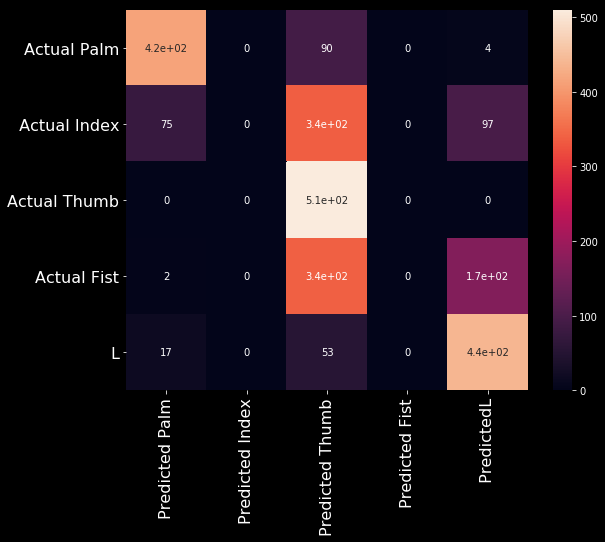

In [39]:
cm_os = pd.DataFrame(cm_model, index=['Actual Palm', ' Actual Index', 'Actual Thumb', 'Actual Fist','L'], 
                     columns = ['Predicted Palm', 'Predicted Index', 'Predicted Thumb', 'Predicted Fist', ' PredictedL'])
plt.style.use("dark_background")
plt.figure(figsize= (9,7))
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
sns.heatmap(cm_os, annot=True)

In [12]:
#A quick function to make graphs
def graph_fart(history, title1, title2):
    plt.figure(figsize = (17,9))
    plt.style.use("dark_background")
    plt.title(title1, fontsize = 28)
    plt.xlabel("Epoch", fontsize = 24)
    plt.ylabel("Loss", fontsize = 24)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.plot(history.history['loss'], label='Train loss', linewidth = 7)
    plt.plot(history.history['val_loss'], label='Val Loss', linewidth= 7 )
    plt.legend(fontsize= 24);
    
    plt.figure(figsize = (17,9))
    plt.title(title2, fontsize = 28)
    plt.xlabel("Epoch", fontsize = 24)
    plt.ylabel("Accuracy", fontsize = 24)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.plot(history.history['acc'], label='Train accuracy', linewidth = 7)
    plt.plot(history.history['val_acc'], label='Val accuracy', linewidth= 7 )
    plt.legend(fontsize= 24);

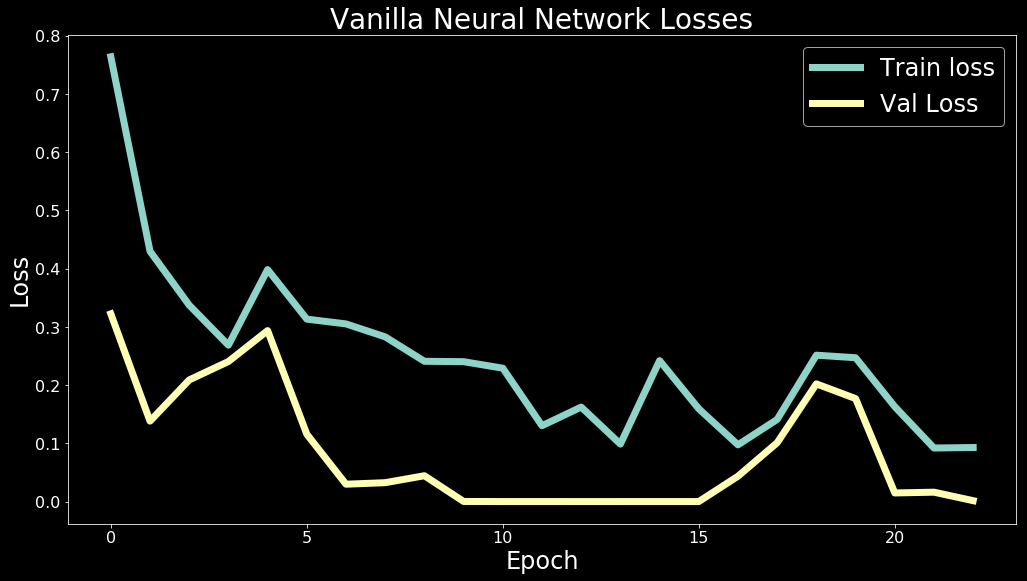

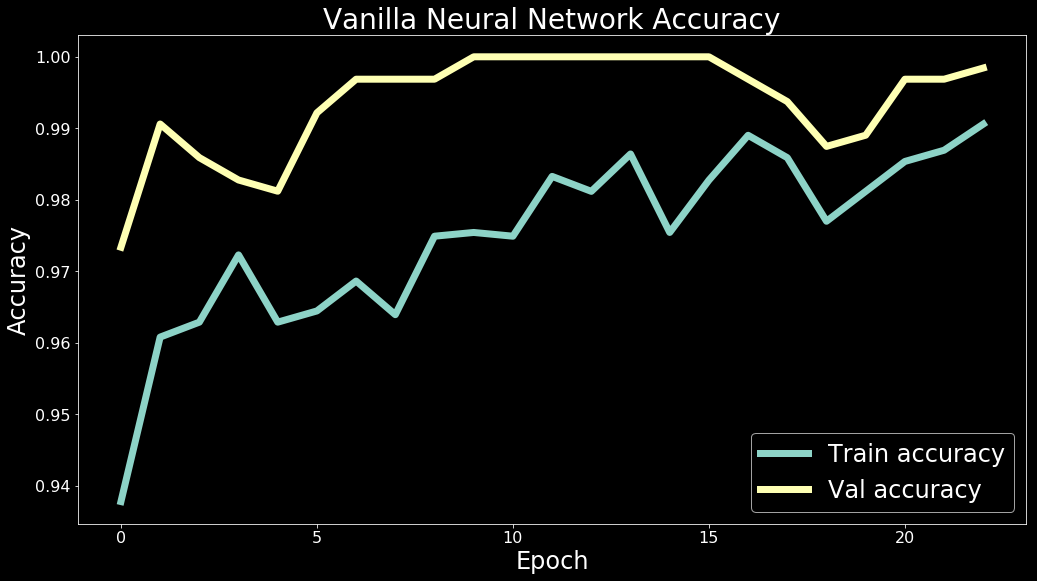

In [43]:
graph_fart(history, "Vanilla Neural Network Losses", "Vanilla Neural Network Accuracy")


In [26]:
model.save("../models/vanilla_NN")

## Convolutional Neural Network


In [30]:
import gc
gc.collect()

0

In [15]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, 
                           verbose=1, mode='auto')

In [19]:

cnn_model=Sequential()

cnn_model.add(Conv2D(filters = 10,            # number of filters
                     kernel_size = 5,        # height/width of filter
                     activation='relu',      # activation function 
                     #kernel_regularizer=regularizers.l2(0.01),
                     input_shape=(120, 320,1))) # shape of input (image)


cnn_model.add(MaxPooling2D(pool_size=(2,2))) # dimensions of region of pooling

cnn_model.add(Conv2D(128,
                     kernel_size=3,
                     #kernel_regularizer=regularizers.l2(0.01),
                     activation='relu'))

cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Flatten())

# Add a densely-connected layer with 128 neurons.
cnn_model.add(Dense(128, activation='relu',
             #kernel_regularizer=regularizers.l2(0.01)
                   )
             )

cnn_model.add(Dropout(.5))

# Add a densely-connected layer with 6 neurons.
cnn_model.add(Dense(y_train.shape[1], activation='relu',
             #kernel_regularizer=regularizers.l2(0.01)
                   ))


cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fit model on training data
# cnn_history = cnn_model.fit(X_train,
#                         y_train,
#                         batch_size=128,
#                         validation_data=(X_test, y_test),
#                         epochs=20,
#                         verbose=1)



# rando = RandomizedSearchCV(estimator=cnn_model,
#                            param_distributions= 
#                            {'batch_size' : [10,20,30,40,50,60,70,80,90,100],
#                             'validation_data':(X_test, y_test),
#                             'epochs':100,
#                             'verbose':1,
#                             'callbacks':[early_stop],
#                             },
#                     cv=5,
#                     verbose = 1,
#                     n_jobs = -1)

cnn_history = cnn_model.fit(X_train,
                        y_train,
                        batch_size=64,
                        validation_data=(X_test, y_test),
                        epochs=100,
                        verbose=1,
                        callbacks=[early_stop]
                        )
    

# Check out the model summary.


Train on 1875 samples, validate on 625 samples
Epoch 1/100
1875/1875 [==============================] - 12s 7ms/step - loss: 2.1068 - acc: 0.2277 - val_loss: 1.5440 - val_acc: 0.3088
Epoch 2/100
1875/1875 [==============================] - 10s 5ms/step - loss: 1.4819 - acc: 0.3701 - val_loss: 1.1904 - val_acc: 0.6816
Epoch 3/100
1875/1875 [==============================] - 10s 5ms/step - loss: 1.2931 - acc: 0.5781 - val_loss: 0.8949 - val_acc: 0.8448
Epoch 4/100
1875/1875 [==============================] - 10s 5ms/step - loss: 1.1082 - acc: 0.7525 - val_loss: 0.6160 - val_acc: 0.8800
Epoch 5/100
1875/1875 [==============================] - 10s 5ms/step - loss: 0.9375 - acc: 0.7792 - val_loss: 0.4843 - val_acc: 0.8976
Epoch 6/100
1875/1875 [==============================] - 10s 5ms/step - loss: 0.8076 - acc: 0.8603 - val_loss: 0.4088 - val_acc: 0.9264
Epoch 7/100
1875/1875 [==============================] - 10s 5ms/step - loss: 0.5736 - acc: 0.8965 - val_loss: 0.3471 - val_acc: 0.9600
E

In [20]:
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 116, 316, 10)      260       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 58, 158, 10)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 156, 128)      11648     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 78, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 279552)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               35782784  
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

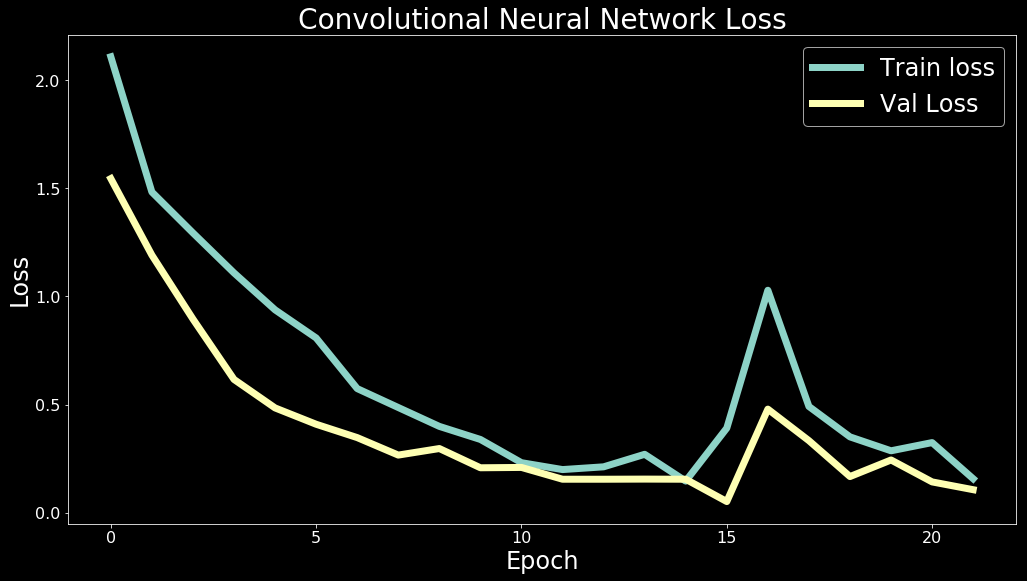

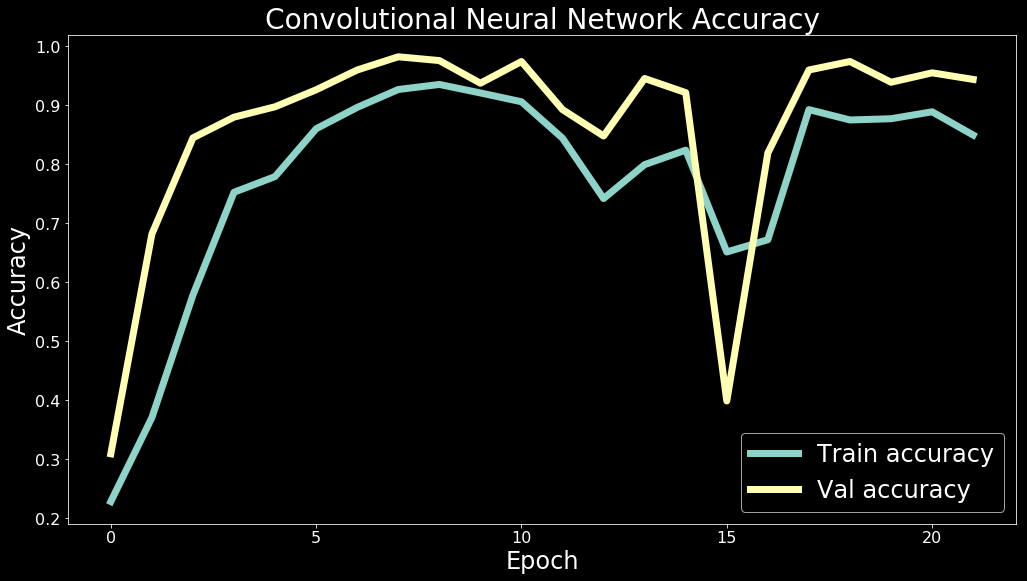

In [22]:
graph_fart(cnn_history, "Convolutional Neural Network Loss", 
           "Convolutional Neural Network Accuracy")

In [24]:
cnn_model.save("../models/cnn_model")

In [25]:
 X_train, X_test, X_train_sc, X_test_sc, y_train, y_test = funky_reader("../csv/data2.csv")

In [26]:
cnn_history = cnn_model.fit(X_train,
                        y_train,
                        batch_size=64,
                        validation_data=(X_test, y_test),
                        epochs=100,
                        verbose=1,
                        callbacks=[early_stop]
                        )

Train on 1912 samples, validate on 638 samples
Epoch 1/100
1912/1912 [==============================] - 11s 6ms/step - loss: 0.6637 - acc: 0.7422 - val_loss: 0.5437 - val_acc: 0.8981
Epoch 2/100
1912/1912 [==============================] - 10s 5ms/step - loss: 0.6595 - acc: 0.8180 - val_loss: 0.4621 - val_acc: 0.9592
Epoch 3/100
1912/1912 [==============================] - 10s 5ms/step - loss: 0.6891 - acc: 0.8117 - val_loss: 0.3967 - val_acc: 0.9608
Epoch 4/100
1912/1912 [==============================] - 10s 5ms/step - loss: 0.6581 - acc: 0.7599 - val_loss: 0.1783 - val_acc: 0.8088
Epoch 5/100
1912/1912 [==============================] - 10s 5ms/step - loss: 0.2747 - acc: 0.7003 - val_loss: 0.1311 - val_acc: 0.8558
Epoch 6/100
1912/1912 [==============================] - 10s 5ms/step - loss: 0.2829 - acc: 0.7934 - val_loss: 0.2096 - val_acc: 0.9843
Epoch 7/100
1912/1912 [==============================] - 10s 5ms/step - loss: 0.1912 - acc: 0.8274 - val_loss: 0.0804 - val_acc: 0.9530
E

In [27]:
cnn_model.save("../models/cnn_model2")

In [9]:
cnn_model = load_model(("../models/cnn_model2"))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [13]:
X_train, X_test, X_train_sc, X_test_sc, y_train, y_test = funky_reader("../csv/data3.csv")

In [17]:
cnn_history = cnn_model.fit(X_train,
                        y_train,
                        batch_size=64,
                        validation_data=(X_test, y_test),
                        epochs=100,
                        verbose=1,
                        callbacks=[early_stop]
                        )

Train on 1912 samples, validate on 638 samples
Epoch 1/100
1912/1912 [==============================] - 10s 5ms/step - loss: 0.4600 - acc: 0.7097 - val_loss: 0.4061 - val_acc: 0.8589
Epoch 2/100
1912/1912 [==============================] - 10s 5ms/step - loss: 0.4340 - acc: 0.7354 - val_loss: 0.4295 - val_acc: 0.8323
Epoch 3/100
1912/1912 [==============================] - 10s 5ms/step - loss: 0.4094 - acc: 0.7139 - val_loss: 0.3790 - val_acc: 0.7790
Epoch 4/100
1912/1912 [==============================] - 10s 5ms/step - loss: 0.6179 - acc: 0.6323 - val_loss: 0.3877 - val_acc: 0.9122
Epoch 5/100
1912/1912 [==============================] - 10s 5ms/step - loss: 0.5432 - acc: 0.7981 - val_loss: 0.4117 - val_acc: 0.9420
Epoch 6/100
1912/1912 [==============================] - 10s 5ms/step - loss: 0.4534 - acc: 0.8190 - val_loss: 0.3840 - val_acc: 0.9295
Epoch 00006: early stopping


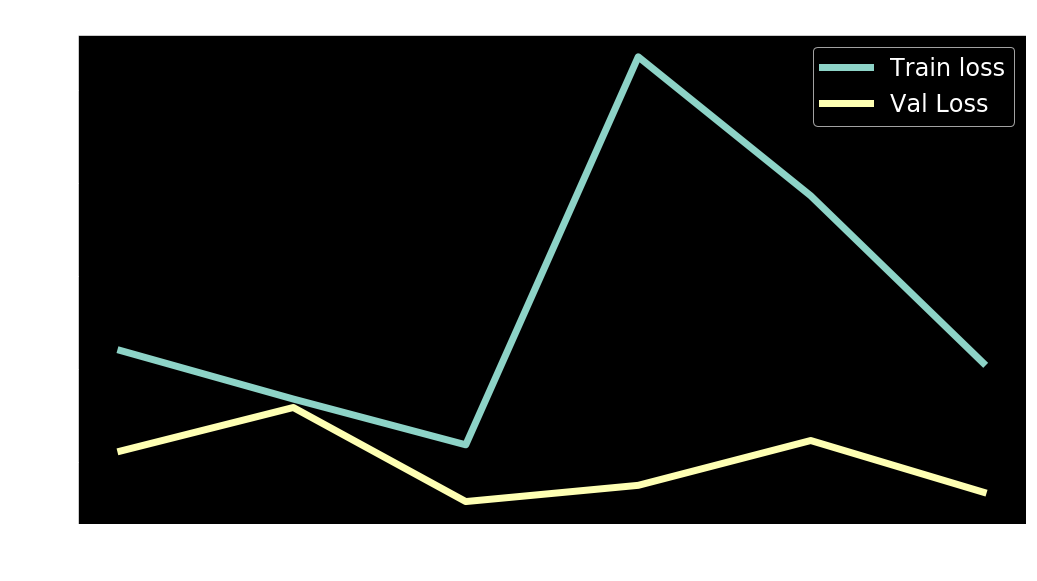

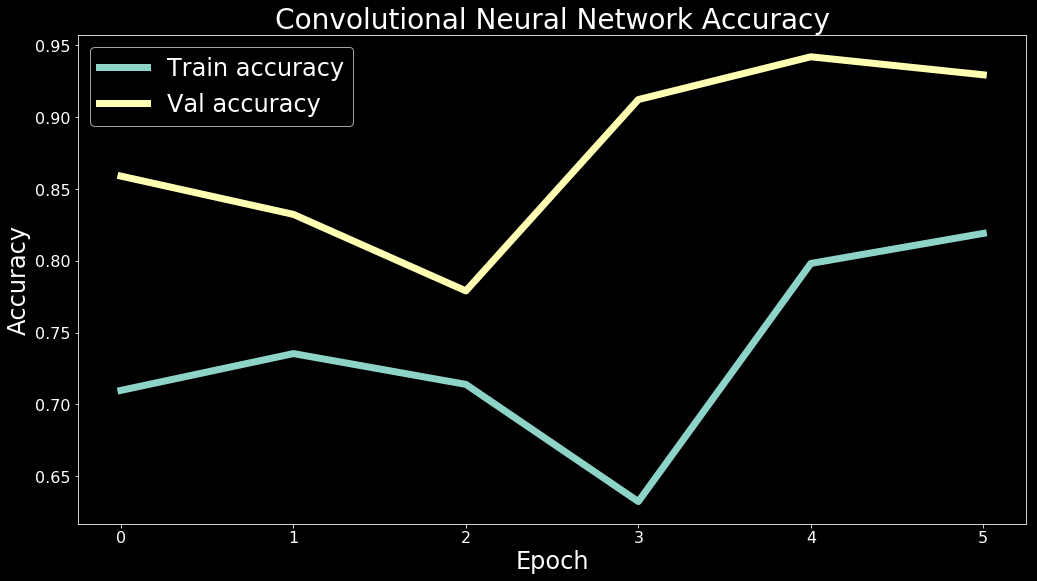

In [31]:
graph_fart(cnn_history, "Convolutional Neural Network Loss", 
           "Convolutional Neural Network Accuracy")

In [18]:
cnn_model.save("../models/cnn_model3")

In [40]:
cnn_model = load_model("../models/cnn_model3")

In [ ]:
ann_viz(cnn_model, filename="cnn.gz" title = "Convolutional Neural network")

In [45]:
X_train, X_test, X_train_sc, X_test_sc, y_train, y_test = funky_reader("../csv/data4.csv")

In [46]:
y = df.iloc[:, 1:]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state =42)

In [46]:
y = y.reshape(y.shape[0], 120, 320, 1)

AttributeError: 'Series' object has no attribute 'reshape'

In [48]:
cnn_preds = cnn_model.predict_classes(X_train)

In [49]:
from sklearn.metrics import confusion_matrix

In [53]:
cm_os = confusion_matrix(X_test, cnn_preds)

ValueError: Found input variables with inconsistent numbers of samples: [638, 1912]

In [ ]:
cnn_model.predict(df)

## Conclusion:
I was not able to get the prediction here correctly in time. It is extremely strange that the Feed Forward Neural Network is outperforming the Convolutional Neural Network even after a lot of tuning. The confusion matrix however is very puzzling, the model (despite having a very high accuracy rate) never predicted index or fist. There seems to be something wrong with the model and I will have to investigate it in the future. 